In [1]:
# importing library packages
from datetime import datetime, timedelta
import os

import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import quanp as qp
import re
from tqdm import tqdm

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

from IPython.display import display
from matplotlib import rcParams

# setting visualization/logging parameters
pd.set_option('display.max_columns', None)
qp.set_figure_params(dpi=100, color_map = 'viridis_r')
qp.settings.verbosity = 1
qp.logging.print_versions()

In [162]:
# prepare End of Day (eod) for each company
df_tickers = pd.read_csv('data/df_daily_logreturn.csv', index_col=0)

df_price_volume = qp.datasets.process_eod_price_volume(df_tickers.columns, startdate='2015-07-31', enddate='2021-02-19')

display(df_price_volume[:2])
display(df_price_volume[-2:])

AAPL_close  AAPL_volume  MSFT_close  MSFT_volume  \
2015-07-31 00:00:00+00:00      30.325    171539812       46.70     31201480   
2015-08-03 00:00:00+00:00      29.610    279903872       46.81     24125886   

                           AMZN_close  AMZN_volume  GOOG_close  GOOG_volume  \
2015-07-31 00:00:00+00:00      536.15      3025598      625.61      1706149   
2015-08-03 00:00:00+00:00      535.03      3014236      631.21      1304511   

                           GOOGL_close  GOOGL_volume  FB_close  FB_volume  \
2015-07-31 00:00:00+00:00       657.50       1746094     94.01   46509045   
2015-08-03 00:00:00+00:00       664.72       1567407     94.14   29343117   

                           TSLA_close  TSLA_volume  BRK.B_close  BRK.B_volume  \
2015-07-31 00:00:00+00:00      53.230     11112760       142.74       3074069   
2015-08-03 00:00:00+00:00      51.998     12767370       142.33       2541624   

                           JPM_close  JPM_volume  V_close  V_volume  \
2015-07-31 00:00:00+00:00      68.53    11911818    75.34   8526346   
2015-08-03 00:00:00+00:00      68.53     9980587    75.77   5810801   

                           JNJ_close  JNJ_volume  WMT_close  WMT_volume  \
2015-07-31 00:00:00+00:00     100.21     6216815      71.98     7928371   
2015-08-03 00:00:00+00:00     100.02     6172519      72.18     5131845   

                           MA_close  MA_volume  DIS_close  DIS_volume  \
2015-07-31 00:00:00+00:00     97.40    3956686     120.00     5767280   
2015-08-03 00:00:00+00:00     97.44    2989773     121.12     8426894   

                           NVDA_close  NVDA_volume  UNH_close  UNH_volume  \
2015-07-31 00:00:00+00:00       19.95      5459211     121.40     3592980   
2015-08-03 00:00:00+00:00       20.29      9928278     120.89     2541250   

                           PG_close  PG_volume  BAC_close  BAC_volume  \
2015-07-31 00:00:00+00:00      76.7   11877236      17.88    67176946   
2015-08-03 00:00:00+00:00      76.4    9511261      17.77    62376780   

                           PYPL_close  PYPL_volume  HD_close  HD_volume  \
2015-07-31 00:00:00+00:00       38.70     12480580    117.03    4301198   
2015-08-03 00:00:00+00:00       39.39     15126574    116.89    3645105   

                           INTC_close  INTC_volume  NFLX_close  NFLX_volume  \
2015-07-31 00:00:00+00:00       28.95     27158763      114.31     16349071   
2015-08-03 00:00:00+00:00       29.05     26213584      112.56     10144817   

                           CMCSA_close  CMCSA_volume  XOM_close  XOM_volume  \
2015-07-31 00:00:00+00:00       31.205      19433518      79.21    26232661   
2015-08-03 00:00:00+00:00       31.605      19139134      78.06    15767743   

                           VZ_close  VZ_volume  ADBE_close  ADBE_volume  \
2015-07-31 00:00:00+00:00     46.79   12562865       81.99      2893613   
2015-08-03 00:00:00+00:00     46.97   10321273       81.40      2073985   

                           KO_close  KO_volume  ABT_close  ABT_volume  \
2015-07-31 00:00:00+00:00     41.08   15309490      50.69     5573486   
2015-08-03 00:00:00+00:00     41.54   14672571      50.50     3506624   

                           NKE_close  NKE_volume  CRM_close  CRM_volume  \
2015-07-31 00:00:00+00:00     57.610     5078650      73.30     2144550   
2015-08-03 00:00:00+00:00     57.415     4991998      72.44     2581418   

                           T_close  T_volume  CVX_close  CVX_volume  \
2015-07-31 00:00:00+00:00    34.74  29880938      88.48    19063381   
2015-08-03 00:00:00+00:00    34.66  29677589      85.60    14142213   

                           LLY_close  LLY_volume  CSCO_close  CSCO_volume  \
2015-07-31 00:00:00+00:00      84.51     4113617       28.42     20375986   
2015-08-03 00:00:00+00:00      84.14     4815748       28.36     17450923   

                           ORCL_close  ORCL_volume  ABBV_close  ABBV_volume  \
2015-07-31 00:00:00+00:00       39.94   13706065.0       70.01  

AAPL_close  AAPL_volume  MSFT_close  MSFT_volume  \
2021-02-18 00:00:00+00:00      129.71     96856748      243.79     16925563   
2021-02-19 00:00:00+00:00      129.87     87668834      240.97     25262600   

                           AMZN_close  AMZN_volume  GOOG_close  GOOG_volume  \
2021-02-18 00:00:00+00:00     3328.23      3033607     2117.20      1121855   
2021-02-19 00:00:00+00:00     3249.90      4305184     2101.14      1457612   

                           GOOGL_close  GOOGL_volume  FB_close  FB_volume  \
2021-02-18 00:00:00+00:00      2105.81       1128549    269.39   15249134   
2021-02-19 00:00:00+00:00      2088.81       1896939    261.56   25622587   

                           TSLA_close  TSLA_volume  BRK.B_close  BRK.B_volume  \
2021-02-18 00:00:00+00:00      787.38     17957058       243.50       4049896   
2021-02-19 00:00:00+00:00      781.30     18958255       241.85       4254656   

                           JPM_close  JPM_volume  V_close  V_volume  \
2021-02-18 00:00:00+00:00     145.59    10590274   209.35   7329287   
2021-02-19 00:00:00+00:00     148.02    11969782   204.73  15011520   

                           JNJ_close  JNJ_volume  WMT_close  WMT_volume  \
2021-02-18 00:00:00+00:00     165.74     5191590     137.66    32309133   
2021-02-19 00:00:00+00:00     162.98     8190883     138.34    12201992   

                           MA_close  MA_volume  DIS_close  DIS_volume  \
2021-02-18 00:00:00+00:00    338.46    2394934     183.00    12390770   
2021-02-19 00:00:00+00:00    333.17    4095761     183.65     8834497   

                           NVDA_close  NVDA_volume  UNH_close  UNH_volume  \
2021-02-18 00:00:00+00:00      593.16      5852020     328.41     2385100   
2021-02-19 00:00:00+00:00      597.06      6793103     324.58     2313753   

                           PG_close  PG_volume  BAC_close  BAC_volume  \
2021-02-18 00:00:00+00:00    129.53    6936352      34.19    37541679   
2021-02-19 00:00:00+00:00    127.12    8277918      34.54    54514131   

                           PYPL_close  PYPL_volume  HD_close  HD_volume  \
2021-02-18 00:00:00+00:00      290.81      9715481    283.05    3531964   
2021-02-19 00:00:00+00:00      286.92      9413810    279.64    4079946   

                           INTC_close  INTC_volume  NFLX_close  NFLX_volume  \
2021-02-18 00:00:00+00:00       61.61     17846142      548.22      2457604   
2021-02-19 00:00:00+00:00       63.01     28290116      540.22      2841457   

                           CMCSA_close  CMCSA_volume  XOM_close  XOM_volume  \
2021-02-18 00:00:00+00:00        52.56      14533459      52.02    20627637   
2021-02-19 00:00:00+00:00        52.10      15143787      52.37    22607163   

                           VZ_close  VZ_volume  ADBE_close  ADBE_volume  \
2021-02-18 00:00:00+00:00     56.98   20759946      488.37      1803375   
2021-02-19 00:00:00+00:00     56.45   18689447      479.12      2720714   

                           KO_close  KO_volume  ABT_close  ABT_volume  \
2021-02-18 00:00:00+00:00     50.77   12749841     125.41     5435012   
2021-02-19 00:00:00+00:00     50.11   15968769     123.04     6204206   

                           NKE_close  NKE_volume  CRM_close  CRM_volume  \
2021-02-18 00:00:00+00:00     145.09     4487139     247.01     4159075   
2021-02-19 00:00:00+00:00     142.02     7485950     246.56     4647670   

                           T_close  T_volume  CVX_close  CVX_volume  \
2021-02-18 00:00:00+00:00    29.23  27002688       95.0     9037383   
2021-02-19 00:00:00+00:00    29.00  29702976       95.8     8913854   

                           LLY_close  LLY_volume  CSCO_close  CSCO_volume  \
2021-02-18 00:00:00+00:00     201.12     3919791       46.34     16867524   
2021-02-19 00:00:00+00:00     200.92     3434858       45.68     25117701   

                           ORCL_close  ORCL_volume  ABBV_close  ABBV_volume  \
2021-02-18 00:00:00+00:00       62.07    6262831.0      106.06  

In [160]:
def compute_log_returns(prices):
    """
    Compute log returns for each ticker.
    
    Parameters
    ----------
    prices : DataFrame
        Prices for each ticker and date
    
    Returns
    -------
    log_returns : DataFrame
        Log returns for each ticker and date
    """    
    return np.log(prices) - np.log(prices.shift(1))

In [171]:
from sklearn.impute import SimpleImputer

df_daily_logreturn = compute_log_returns(df_price_volume)[1:]

imputer_median = SimpleImputer(missing_values=np.nan, strategy='median')
imputer_median.fit(df_daily_logreturn)
df_daily_logreturn = pd.DataFrame(imputer_median.transform(df_daily_logreturn),
                                  columns=df_daily_logreturn.columns,
                                  index=df_daily_logreturn.index)

ValueError: Input contains infinity or a value too large for dtype('float64').

# Consider all tickers

In [164]:
nobs = 50
df_train, df_test = df_daily_logreturn[0:-nobs], df_daily_logreturn[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(1348, 300)
(50, 300)


In [165]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
          
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "AAPL_close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.0001
 No. Lags Chosen       = 8
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "AAPL_volume" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.7086
 No. Lags Chosen       = 18
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "MSFT_close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signifi

MissingDataError: exog contains inf or nans

In [166]:
model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

LinAlgError: SVD did not converge in Linear Least Squares

In [170]:
x = model.select_order(maxlags=2)
x.summary()

ValueError: array must not contain infs or NaNs

In [148]:
from statsmodels.stats.stattools import durbin_watson

# some example data
model_fitted = model.fit(45)

out = durbin_watson(model_fitted.resid)

def adjust(val, length= 6): 
    return str(val).ljust(length)

for col, val in zip(df_train.columns, out):
    print(adjust(col), ':', round(val, 2))


AAPL_close : 2.0
AAPL_volume : 2.0


In [149]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_test.values[-lag_order:]

# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_test.index[-nobs:], columns=df_test.columns + '_forecast')

45


In [150]:
from statsmodels.tsa.stattools import acf

df_accuracy = pd.DataFrame(index=df_test.columns)

def forecast_accuracy(forecast, actual):
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})


for col in df_test.iloc[:, 0:30]:
    accuracy_prod = forecast_accuracy(df_forecast['{}_forecast'.format(col)].values, df_test['{}'.format(col)].values)
    for k, v in accuracy_prod.items():
        df_accuracy.at[col, k] = round(v, 4)


In [151]:
ls_col_target = df_accuracy.dropna().sort_values(by=['me']).index
df_accuracy = df_accuracy.dropna().sort_values(by=['me'])

for metric in ['mape', 'me', 'mae', 'mpe', 'rmse', 'minmax']:
    df_accuracy['{}_rank'.format(metric)] = df_accuracy[metric].rank(na_option='bottom', pct=True)

ls_col_target = pd.DataFrame(df_accuracy.filter(like='_rank').sum(axis=1)).sort_values(0, ascending=True).index[:6]

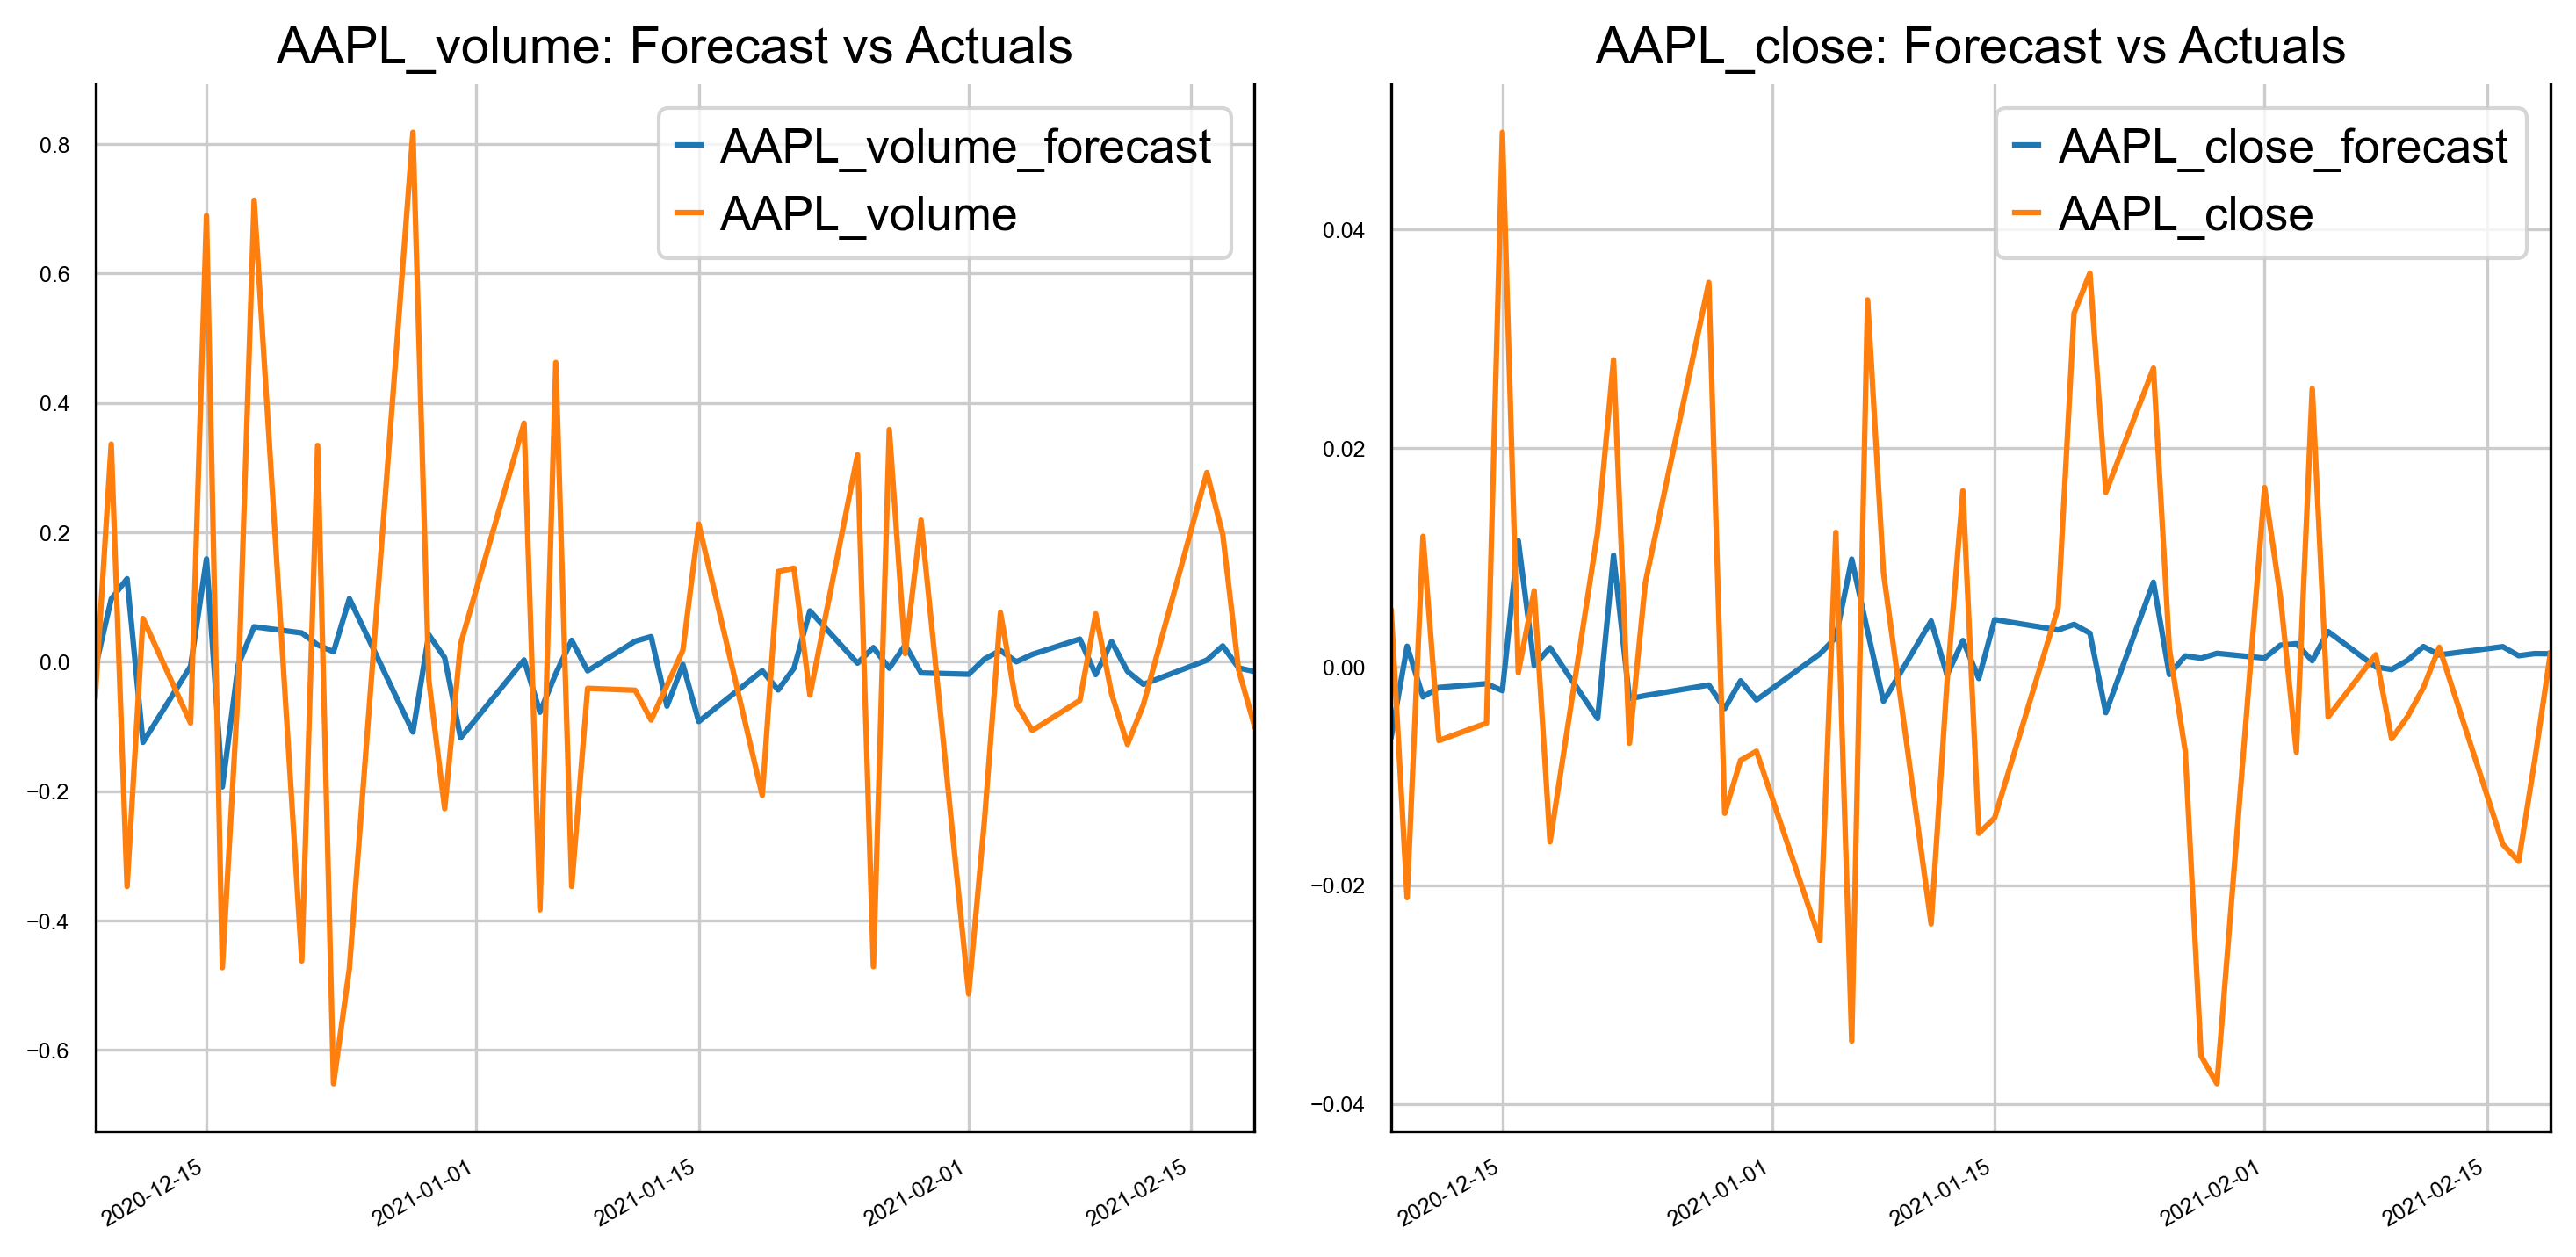

In [152]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(nrows=(int(len(ls_col_target)/2)), ncols=2, dpi=150, figsize=(10,5))

for i, (col,ax) in enumerate(zip(ls_col_target, axes.flatten())):
    df_forecast[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True);
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals");
    ax.xaxis.set_ticks_position('none');
    ax.yaxis.set_ticks_position('none');
    ax.spines["top"].set_alpha(0);
    ax.tick_params(labelsize=6);

plt.tight_layout();

In [31]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: 
                print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

gc_matrix = grangers_causation_matrix(df_daily_logreturn, variables = df_daily_logreturn.columns)

KeyboardInterrupt: 

In [293]:
Median_y = pd.DataFrame(gc_matrix.replace(0, 0.000001).apply(lambda x: -np.log10(x)).median(axis=1), 
                        columns=['Median'])
Median_x = pd.DataFrame(gc_matrix.replace(0, 0.000001).apply(lambda x: -np.log10(x)).median(axis=0), 
                        columns=['Median'])

In [ ]:
ls_top50_median_y = Median_y.sort_values(by=['Median'], ascending=False).index[:int(len(Median_y) * 0.2)]
ls_top50_median_x = Median_x.sort_values(by=['Median'], ascending=False).index[:int(len(Median_x) * 0.2)]

ls_top50_median_y_tickers = [sub.replace('_y', '') for sub in ls_top50_median_y] 
ls_top50_median_x_tickers = [sub.replace('_x', '') for sub in ls_top50_median_x] 

len(set(ls_top50_median_x_tickers + ls_top50_median_y_tickers))

ls_slected_tickers = list(set(ls_top50_median_x_tickers + ls_top50_median_y_tickers))

In [386]:
x = gc_matrix[gc_matrix['AAPL_x'] < 0.001].index
y = gc_matrix.T[gc_matrix.T['AAPL_y'] < 0.001].index
ls_y_tickers = [sub.replace('_x', '') for sub in y] 
ls_x_tickers = [sub.replace('_y', '') for sub in x] 

ls_slected_tickers = list(np.intersect1d(ls_y_tickers, ls_x_tickers)) + ['AAPL']

In [387]:
len(ls_slected_tickers)

33

In [388]:
# pd.plotting.scatter_matrix(pd.DataFrame(gc_matrix.replace(0, 0.000001).apply(lambda x: -np.log10(x))).iloc[:, 0:5],
#                           alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [419]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    
    def adjust(val, length= 6): 
        return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    ls_cointegrated = []
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
        if trace > cvt:
            ls_cointegrated.append(col)
            
    return ls_cointegrated
        
df_daily_logreturn_selected = df_daily_logreturn[ls_slected_tickers]

ls_cointegrated = cointegration_test(df_daily_logreturn_selected)

# df_daily_logreturn_selected = df_daily_logreturn[ls_cointegrated]

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
ABT    ::  3900.98   > nan       =>   False
BA     ::  3547.21   > nan       =>   False
BAC    ::  3232.74   > nan       =>   False
BMY    ::  2941.92   > nan       =>   False
C      ::  2704.57   > nan       =>   False
CB     ::  2471.73   > nan       =>   False
CL     ::  2270.26   > nan       =>   False
CMCSA  ::  2093.42   > nan       =>   False
CME    ::  1925.12   > nan       =>   False
COF    ::  1763.5    > nan       =>   False
COP    ::  1615.39   > nan       =>   False
CSX    ::  1472.46   > nan       =>   False
DIS    ::  1338.43   > nan       =>   False
ECL    ::  1210.01   > nan       =>   False
FB     ::  1090.0    > nan       =>   False
FIS    ::  982.69    > nan       =>   False
GILD   ::  882.36    > nan       =>   False
IBM    ::  789.52    > nan       =>   False
JPM    ::  698.37    > nan       =>   False
MMM    ::  616.89    > nan       =>   False
MS     ::  541.35    > nan     

/Users/leehongkai/anaconda/envs/quanp_py36/lib/python3.6/site-packages/statsmodels/tsa/vector_ar/vecm.py:579: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  category=HypothesisTestWarning)


In [420]:
nobs = 20
df_train, df_test = df_daily_logreturn_selected[0:-nobs], df_daily_logreturn_selected[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(372, 33)
(20, 33)


In [421]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
          
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "ABT" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.1289
 No. Lags Chosen       = 8
 Critical value 1%     = -3.448
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "BA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.0639
 No. Lags Chosen       = 2
 Critical value 1%     = -3.448
 Critical value 5%     = -2.869
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "BAC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Tes

    Augmented Dickey-Fuller Test on "PG" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.5153
 No. Lags Chosen       = 8
 Critical value 1%     = -3.448
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PNC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.9795
 No. Lags Chosen       = 8
 Critical value 1%     = -3.448
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "REGN" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [422]:
model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

/Users/leehongkai/anaconda/envs/quanp_py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag Order = 1
AIC :  -282.8357591410929
BIC :  -270.99215074690005
FPE :  1.490670904134536e-123
HQIC:  -278.13185912554417 

Lag Order = 2
AIC :  -282.4475707860948
BIC :  -259.06174606861856
FPE :  2.4686147347200733e-123
HQIC:  -273.15852181129355 

Lag Order = 3
AIC :  -281.8469614173032
BIC :  -246.8723572836074
FPE :  6.229163107069894e-123
HQIC:  -267.95332434238003 

Lag Order = 4
AIC :  -281.5855448319456
BIC :  -234.97528391992535
FPE :  1.581312206511306e-122
HQIC:  -263.0677478910803 

Lag Order = 5
AIC :  -282.2438649115372
BIC :  -223.95075264003054
FPE :  2.720458493358653e-122
HQIC:  -259.08220247482285 

Lag Order = 6
AIC :  -283.8231563468417
BIC :  -213.79967793032046
FPE :  4.172153856741685e-122
HQIC:  -255.99778766648794 

Lag Order = 7
AIC :  -286.9498429930958
BIC :  -205.14816042041753
FPE :  4.7903186408524187e-122
HQIC:  -254.4407909347609 

Lag Order = 8
AIC :  -293.5197202410946
BIC :  -199.89166921778886
FPE :  1.4384799580830203e-122
HQIC:  -256.306870000

In [423]:
x = model.select_order(maxlags=8)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [424]:
model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 01, Mar, 2021
Time:                     08:36:22
--------------------------------------------------------------------
No. of Equations:         33.0000    BIC:                   -199.892
Nobs:                     364.000    HQIC:                  -256.307
Log likelihood:           45121.3    FPE:               1.43848e-122
AIC:                     -293.520    Det(Omega_mle):    2.08343e-130
--------------------------------------------------------------------
Results for equation ABT
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.003833         0.001723            2.225           0.026
L1.ABT          -0.190910         0.138499           -1.378           0.168
L1.BA           -0.026702         0.067966           -0.393           0.694
L1.BAC

In [425]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

def adjust(val, length= 6): 
    return str(val).ljust(length)

for col, val in zip(df_train.columns, out):
    print(adjust(col), ':', round(val, 2))

ABT    : 1.86
BA     : 2.05
BAC    : 2.01
BMY    : 2.03
C      : 1.92
CB     : 2.08
CL     : 2.03
CMCSA  : 1.94
CME    : 2.0
COF    : 1.98
COP    : 1.98
CSX    : 1.94
DIS    : 2.02
ECL    : 1.97
FB     : 1.84
FIS    : 1.87
GILD   : 1.95
IBM    : 2.03
JPM    : 2.01
MMM    : 2.01
MS     : 1.91
ORCL   : 1.91
PEP    : 2.01
PG     : 2.0
PNC    : 2.0
REGN   : 2.04
RTX    : 1.99
SBUX   : 1.9
SCHW   : 1.94
TFC    : 2.01
USB    : 2.08
VZ     : 2.04
AAPL   : 1.86


In [426]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_test.values[-lag_order:]
forecast_input.shape

8


(8, 33)

In [427]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_test.index[-nobs:], columns=df_test.columns + '_forecast')
# df_forecast

/Users/leehongkai/anaconda/envs/quanp_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/Users/leehongkai/anaconda/envs/quanp_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/Users/leehongkai/anaconda/envs/quanp_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/Users/leehongkai/anaconda/envs/quanp_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/Users/leehongkai/anaconda/envs/quanp_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235:

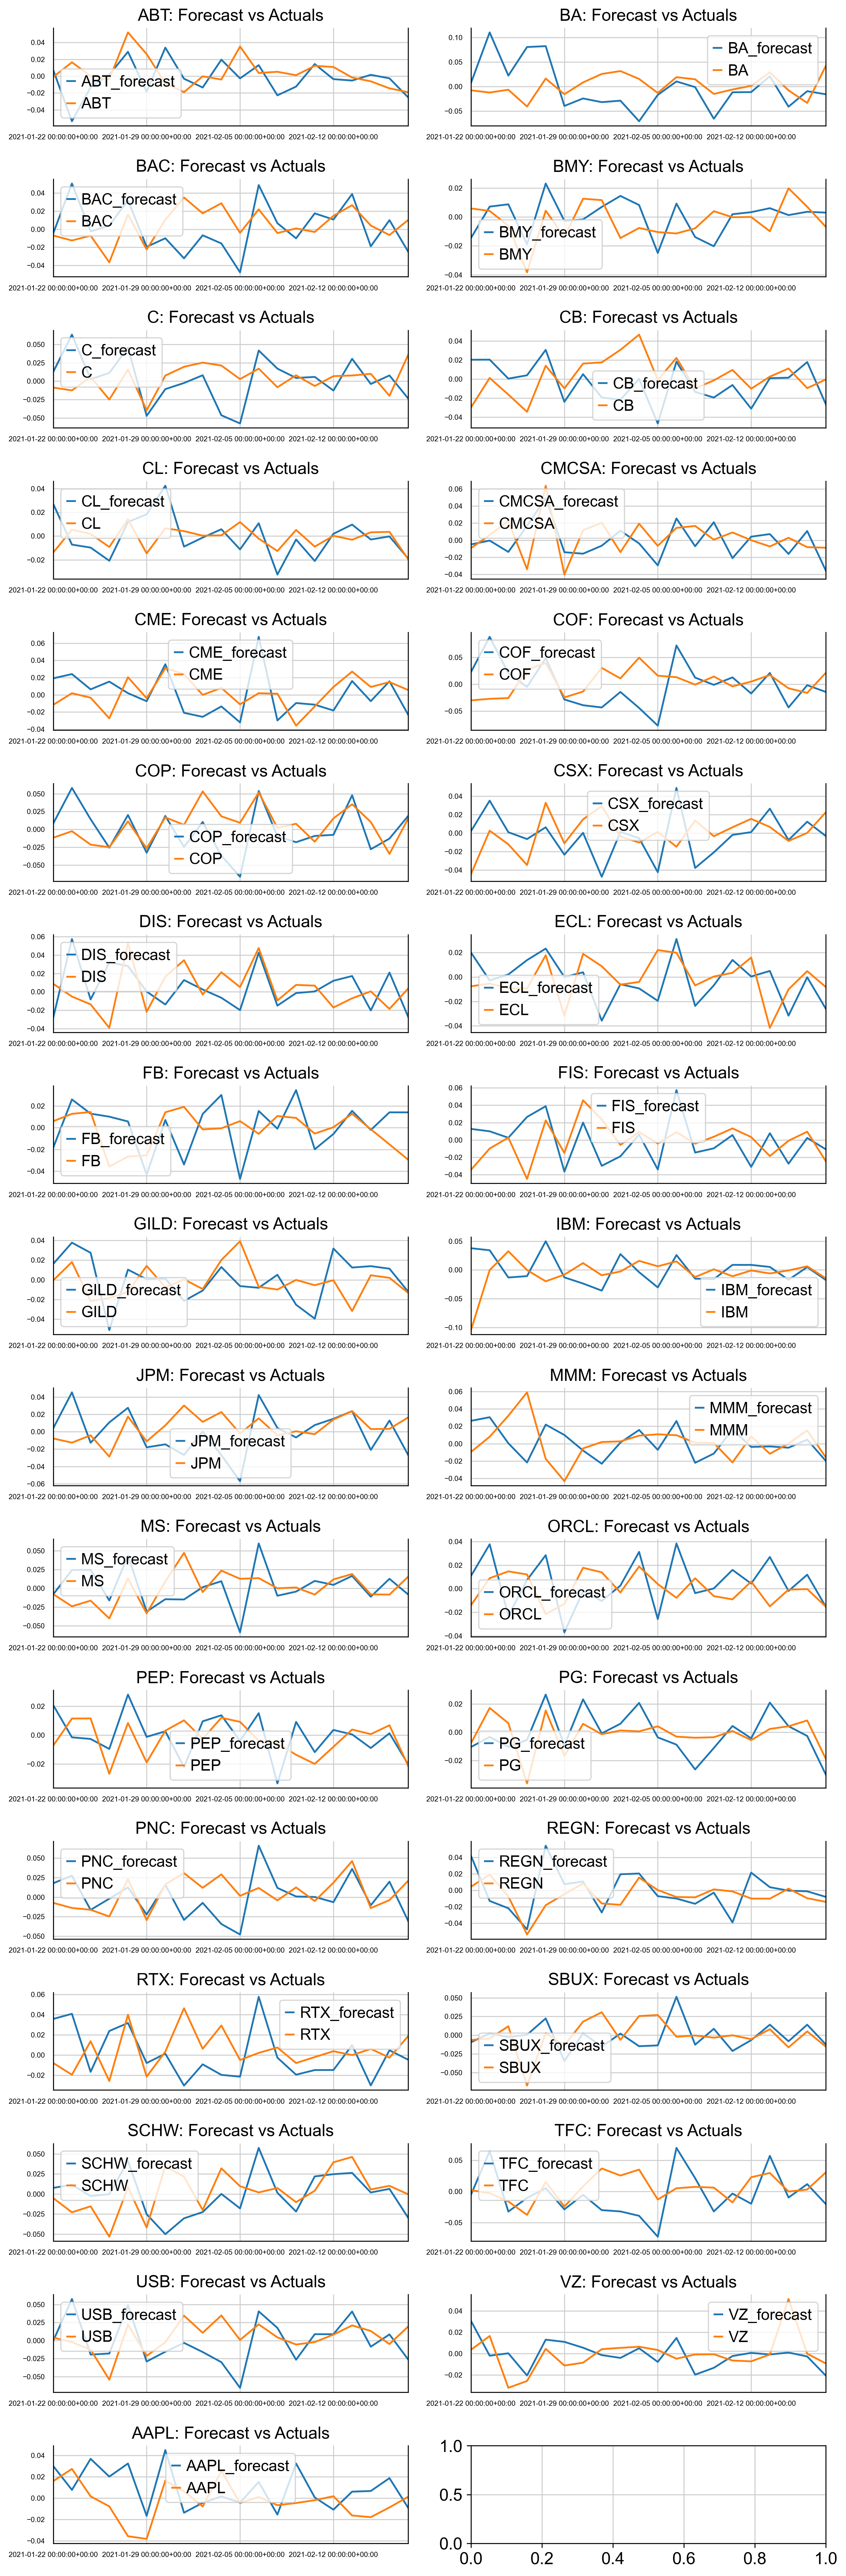

In [432]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=(int(len(df_test.columns)/2)+1), ncols=2, dpi=150, figsize=(10,30))

for i, (col,ax) in enumerate(zip(df_test.columns, axes.flatten())):
    df_forecast[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True);
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals");
    ax.xaxis.set_ticks_position('none');
    ax.yaxis.set_ticks_position('none');
    ax.spines["top"].set_alpha(0);
    ax.tick_params(labelsize=6);

plt.tight_layout();


In [429]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

for col in df_test.iloc[:, 0:30]:
    print('Forecast Accuracy of: {}'.format(col))
    accuracy_prod = forecast_accuracy(df_forecast['{}_forecast'.format(col)].values, df_test['{}'.format(col)].values)
    for k, v in accuracy_prod.items():
        print(adjust(k), ': ', round(v,4))



Forecast Accuracy of: ABT
mape   :  14.4322
me     :  -0.0071
mae    :  0.0197
mpe    :  -5.9154
rmse   :  0.0259
corr   :  0.0799
minmax :  4.997
Forecast Accuracy of: BA
mape   :  2.9942
me     :  -0.004
mae    :  0.0417
mpe    :  -1.542
rmse   :  0.0544
corr   :  -0.1932
minmax :  0.9393
Forecast Accuracy of: BAC
mape   :  3.0463
me     :  -0.0028
mae    :  0.0245
mpe    :  -1.6916
rmse   :  0.0307
corr   :  0.0326
minmax :  1.5886
Forecast Accuracy of: BMY
mape   :  inf
me     :  0.0029
mae    :  0.0135
mpe    :  inf
rmse   :  0.0155
corr   :  0.229
minmax :  1.1113
Forecast Accuracy of: C
mape   :  2.9609
me     :  -0.0008
mae    :  0.0284
mpe    :  -2.3091
rmse   :  0.0351
corr   :  -0.0105
minmax :  2.5868
Forecast Accuracy of: CB
mape   :  7.3009
me     :  -0.0069
mae    :  0.0238
mpe    :  5.7451
rmse   :  0.0285
corr   :  -0.0045
minmax :  -1.9122
Forecast Accuracy of: CL
mape   :  3.136
me     :  0.0009
mae    :  0.0134
mpe    :  -0.7023
rmse   :  0.0176
corr   :  0.2133
min

/Users/leehongkai/anaconda/envs/quanp_py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/leehongkai/anaconda/envs/quanp_py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/leehongkai/anaconda/envs/quanp_py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
